# RNN WORKFLOW (UNESCO DATASET)
Status: **DONE**

In [1]:
# IMPORT ALL LIBRARIES
import sys
import os
import re
import string
import importlib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../../..")))


from sklearn.metrics import  ConfusionMatrixDisplay, confusion_matrix, accuracy_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from shared.metrics import compute_classic_metrics, save_evaluation_report

importlib.reload(sys.modules['shared.metrics'])



<module 'shared.metrics' from 'c:\\Users\\mosqu\\personal-projects\\dss_pit\\src\\shared\\metrics.py'>

In [13]:
# LOAD DATASET

df = pd.read_csv("../../../data/unesco/cleaned_dataset.csv")

df.columns = ['text', 'label']

print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
print(df.head())
print("\nLabel distribution:")
print(df['label'].value_counts())

print("\nData types and non-null values:")
df.info()

print("\nDescriptive statistics:")
print(df.describe())

Dataset shape: (5636, 2)

First 5 rows:
                                                text            label
0  india middle youtube frenzy going get people k...       Conspiracy
1  tweet false reporting shooting people virus ch...  False reporting
2  tweet woman eating delicacy attributing virus ...  False reporting
3  tweet false chain message need containment act...  False reporting
4  hoax alert viral emergency notification fake c...  False reporting

Label distribution:
label
False reporting                 4123
Conspiracy                       966
Fake remedy                      502
Conspiracy, False reporting        5
False Reporting                    3
false reporting                    3
Fake remedy, false reporting       2
False reporting, Fake remedy       1
Conspiracy, Fake remedy            1
Fake remedy, False reporting       1
False reporting, Conspiracy        1
Fake remedy, conspiracy            1
Name: count, dtype: int64

Data types and non-null values:
<class 'pa

In [14]:
initial_rows = df.shape[0]
df.dropna(subset=["text", "label"], inplace=True)

rows_after_dropping_na = df.shape[0]

print(f"Initial number of rows: {initial_rows}")
print(f"Number of rows after dropping NaNs: {rows_after_dropping_na}")
print(f"Number of rows removed: {initial_rows - rows_after_dropping_na}")

Initial number of rows: 5636
Number of rows after dropping NaNs: 5609
Number of rows removed: 27


In [15]:
def standardize_label(label):
    """Standardizes the label by lowercasing and replacing variations."""

    # 1. Lowercase for case insensitivity
    label = str(label).lower().strip()

    # 2. Simple replacements/corrections
    if 'false reporting' in label:
        return 'False reporting'
    if 'conspiracy' in label:
        return 'Conspiracy'
    if 'fake remedy' in label:
        return 'Fake remedy'
    return label # Return the original if none of the majors are found

# Apply the standardization function
df['label_cleaned'] = df['label'].apply(standardize_label)

print("--- After Initial Standardization ---")
print(df['label_cleaned'].value_counts())

--- After Initial Standardization ---
label_cleaned
False reporting    4139
Conspiracy          968
Fake remedy         502
Name: count, dtype: int64


In [16]:
print(f"NaN count before drop: {df['label_cleaned'].isna().sum()}")

# 2. Drop rows where 'text' or 'label_cleaned' is NaN
# We use dropna() with subset to target only the critical columns
df_cleaned = df.dropna(subset=['text', 'label_cleaned'])

# 3. Final verification
print(f"\nNew Dataset shape after drop: {df_cleaned.shape}")
print(f"NaN count after drop: {df_cleaned['label_cleaned'].isna().sum()}")

NaN count before drop: 0

New Dataset shape after drop: (5609, 3)
NaN count after drop: 0


In [17]:
MAJOR_CLASSES = ['False reporting', 'Conspiracy', 'Fake remedy']
DOMINANT_CLASS = 'False reporting'

def consolidate_compound_labels(label):
    """Merges non-major classes into the dominant class."""
    if label in MAJOR_CLASSES:
        return label
    else:
        return DOMINANT_CLASS

# Apply the consolidation function to the new df_cleaned
df_cleaned['Y'] = df_cleaned['label_cleaned'].apply(consolidate_compound_labels)

# Final Result Verification
print("\n--- Final Consolidated Label Distribution (After NaN Drop) ---")
print(df_cleaned['Y'].value_counts())

# Drop intermediate columns
df_final = df_cleaned.drop(columns=['label', 'label_cleaned'])
df_final.columns = ['X', 'Y'] # Rename to X and Y for the model notebook

print(f"\nFinal Ready Dataset Shape: {df_final.shape}")


--- Final Consolidated Label Distribution (After NaN Drop) ---
Y
False reporting    4139
Conspiracy          968
Fake remedy         502
Name: count, dtype: int64

Final Ready Dataset Shape: (5609, 2)


In [19]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_final["Y"])

print("Encoded labels (first 5):")
print(y[:5])
print("Original classes:")
print(label_encoder.classes_)

Encoded labels (first 5):
[0 2 2 2 2]
Original classes:
['Conspiracy' 'Fake remedy' 'False reporting']


In [20]:
# Initialize Tokenizer
# Using num_words=None to keep all words, or specify a number if desired
tokenizer = Tokenizer(num_words=None, oov_token="<unk>")

# Fit tokenizer on the 'combined_text' column
tokenizer.fit_on_texts(df_final["X"])

# Convert text to sequences of integers
sequences = tokenizer.texts_to_sequences(df_final["X"])

print(f"Vocabulary size: {len(tokenizer.word_index)}")
print("First 5 text sequences (partial view):")
for i in range(5):
    print(sequences[i][:10])  # Print first 10 tokens of first 5 sequences

Vocabulary size: 21038
First 5 text sequences (partial view):
[136, 1565, 578, 8182, 209, 130, 6, 252, 5113, 3838]
[144, 12, 270, 3839, 6, 11, 20, 227, 306, 1566]
[144, 182, 226, 5114, 3091, 11, 226, 413, 1567, 227]
[144, 12, 360, 42, 244, 3093, 1942, 360, 42, 244]
[140, 1417, 90, 124, 1734, 22, 360, 42, 228, 28]


In [22]:
# Determine an appropriate maximum sequence length
sequence_lengths = [len(seq) for seq in sequences]
max_sequence_length = int(np.percentile(sequence_lengths, 90))

# Pad the sequences
X = pad_sequences(
    sequences, maxlen=max_sequence_length, padding="post", truncating="post"
)

print(f"Original max sequence length: {max(sequence_lengths)}")
print(f"Selected max sequence length for padding: {max_sequence_length}")
print(f"Shape of padded sequences (X): {X.shape}")
print("First padded sequence (partial view):\n", X[0][: max_sequence_length // 10])

Original max sequence length: 65
Selected max sequence length for padding: 27
Shape of padded sequences (X): (5609, 27)
First padded sequence (partial view):
 [ 136 1565]


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (4487, 27)
Shape of X_test: (1122, 27)
Shape of y_train: (4487,)
Shape of y_test: (1122,)


In [24]:
vocabulary_size = len(tokenizer.word_index) + 1

# Get number of classes
num_classes = len(label_encoder.classes_)

# Define the model
model = Sequential(
    [
        Embedding(input_dim=vocabulary_size, output_dim=128),
        LSTM(units=128),
        Dense(units=num_classes, activation="softmax"),
    ]
)

# Explicitly build the model before compiling or summarizing
# input_shape should be (batch_size, sequence_length)
model.build(input_shape=(None, max_sequence_length))

# Compile the model
model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

# Print model summary
print("RNN Model Summary:")
model.summary()

RNN Model Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 27, 128)        │     2,692,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,824,963 (10.78 MB)

 Trainable params: 2,824,963 (10.78 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))
print("Model training complete. Training history stored in 'history' variable.")

Epoch 1/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - accuracy: 0.7421 - loss: 0.7231 - val_accuracy: 0.7487 - val_loss: 0.6343
Epoch 2/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.8150 - loss: 0.4569 - val_accuracy: 0.7130 - val_loss: 0.6357
Epoch 3/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.9247 - loss: 0.2335 - val_accuracy: 0.7273 - val_loss: 0.8057
Epoch 4/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.9659 - loss: 0.1300 - val_accuracy: 0.7816 - val_loss: 0.5913
Epoch 5/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.9819 - loss: 0.0739 - val_accuracy: 0.7594 - val_loss: 0.9280
Epoch 6/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.9884 - loss: 0.0500 - val_accuracy: 0.7754 - val_loss: 0.9845
Epoch 7/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.9911 - loss: 0.0373 - val_accuracy: 0.7683 - val_loss: 0.7879
Epoch 8/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.9909 - loss: 0.0434 - val_acc

In [26]:
# Make predictions on the test set
y_pred_prob = model.predict(X_test)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)

# Generate and print the classification report
print("Classification Report:")
# Provide all possible labels to classification_report to match target_names
print(
    classification_report(
        y_test,
        y_pred,
        labels=np.arange(num_classes),
        target_names=label_encoder.classes_,
        zero_division=0,
    )
)

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Classification Report:
                 precision    recall  f1-score   support

     Conspiracy       0.47      0.51      0.49       208
    Fake remedy       0.74      0.60      0.66       110
False reporting       0.84      0.84      0.84       804

       accuracy                           0.75      1122
      macro avg       0.68      0.65      0.66      1122
   weighted avg       0.76      0.75      0.76      1122



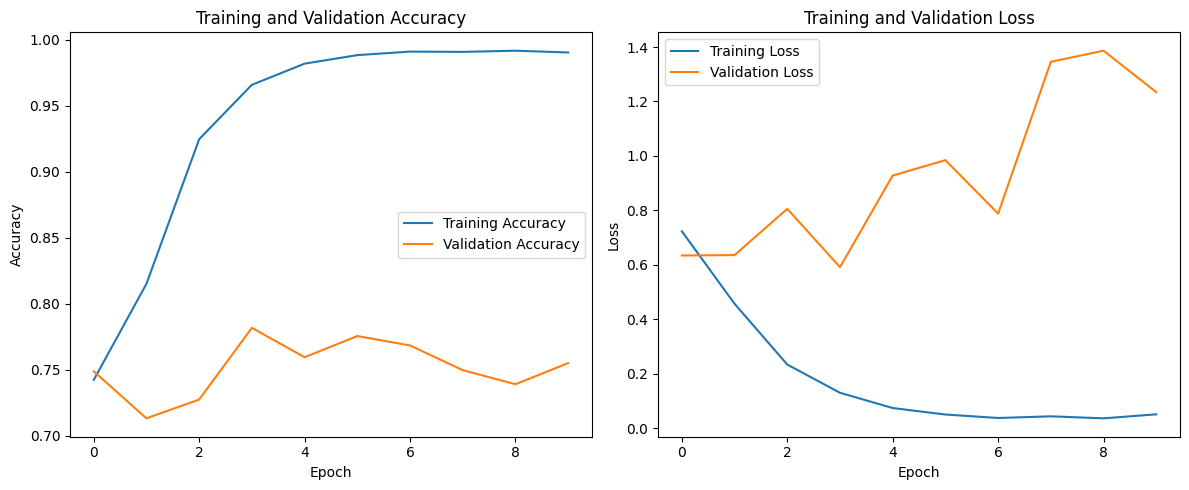

In [27]:
# Get training history
hist = history.history

# Plot training and validation accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(hist['accuracy'], label='Training Accuracy')
plt.plot(hist['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(hist['loss'], label='Training Loss')
plt.plot(hist['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [28]:
# COMPUTE CLASS METRICS
metrics = compute_classic_metrics(y_test, y_pred)

print("Accuracy:", metrics["accuracy"])
print("F1 Score:", metrics["f1_score"])
print(metrics["report"])

Accuracy: 0.7549019607843137
F1 Score: 0.7561978554558528
              precision    recall  f1-score   support

           0       0.47      0.51      0.49       208
           1       0.74      0.60      0.66       110
           2       0.84      0.84      0.84       804

    accuracy                           0.75      1122
   macro avg       0.68      0.65      0.66      1122
weighted avg       0.76      0.75      0.76      1122



In [29]:
class_names = label_encoder.classes_

cm = confusion_matrix(y_test, y_pred)
print("Raw confusion matrix:")
print(cm)

Raw confusion matrix:
[[107   2  99]
 [ 11  66  33]
 [109  21 674]]


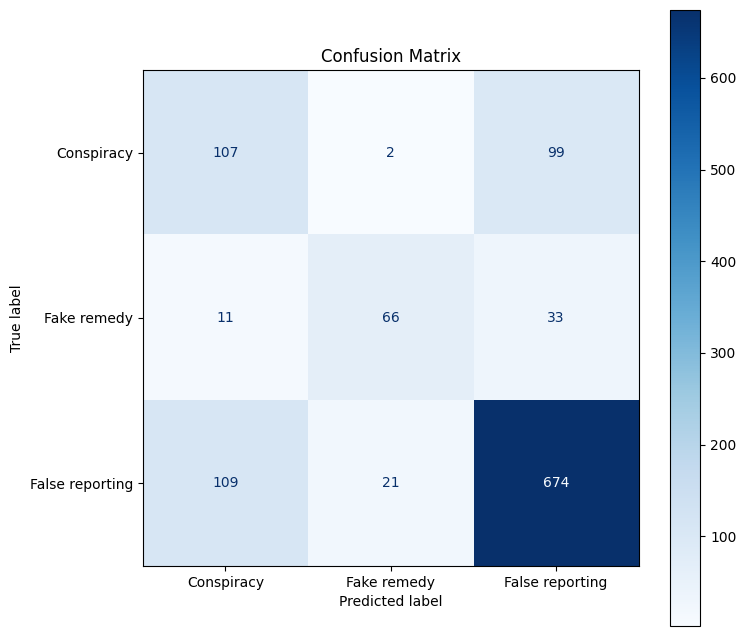

In [31]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Adjust the plot size and color map
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='d') # 'd' formats as integer
plt.title("Confusion Matrix")
plt.show()

In [33]:
save_evaluation_report(metrics, "../../../deep_models/unesco_results/rnn_evaluation_report.json")

Evaluation report saved to ../../../deep_models/unesco_results/rnn_evaluation_report.json
